## 1-dimensional
just 1 observable

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from basic_functions_gaussian import compute_depth, compute_depth_analytical, flatten

- plot limit values of loss, chi2 and S rel. and the depth
- in which cases you might overcome the barrier
- compare with Metropolis sampling
- include the Jeffreys prior: how does it modify the minimum (MAP)?
- effect of correlated frames
- realistic case study: RNA oligomers

### 1. limit values

Analytical estimate:

$\mathcal L_{lim} \simeq \frac{1}{2} \Bigl(\frac{\sigma\bar g(N) - g_{exp}}{\sigma_{exp}}\Bigr)^2 + \alpha \,\log N$

where the max. value of $N$ normally distributed random values $\mathcal N(0,1)$ is estimated as

$\bar g(N) = \sqrt 2 \, \mathrm{inverf}(1-2/N)$.

This is the estimate of $\bar g(N)$ in 1dim (namely, just 1 observable), where we also have the boundaries

$\sqrt{2\log N} - 1 \leq \bar g(N) \leq \sqrt{2\log N}$

so $\bar g (N)\sim \sqrt{2\log N}$. In more than 1d. we can show 

$\bar g(N) \leq \frac{\sqrt{2}}{2} (D+1) \sqrt{\log N}$.

So, at the leading order in $N$, it is

$\mathcal L_{lim} \leq \Bigl[ \frac{(D+1)^2}{4} (\sigma/\sigma_{exp})^2 + \alpha \Bigr]\log N + O(\sqrt{\log N})$

In [3]:
alpha = 0.5

sigma = 0.1
gexp = 0.3
sigma_exp = 0.08

In [4]:
log_ns = np.linspace(1, 6, 10)
ns = np.unique(np.array([int(10**log_n) for log_n in log_ns]))

out1 = {}
out2 = {}

for n in ns:
    
    print(n)

    out1[n] = {}
    
    for m in range(5):
        out1[n][m] = compute_depth(n, sigma, gexp, sigma_exp, alpha, delta_lambda=100)
    
    out2[n] = compute_depth_analytical(n, sigma, gexp, sigma_exp, alpha)

10
35
129
464
1668
5994
21544
77426
278255
1000000


In [5]:
print(vars(out1[n][m]).keys())
print(vars(out2[n]).keys())

dict_keys(['g', 'mini', 'min_lambda', 'min_loss', 'min_avg', 'gbar', 'lim_loss', 'lim_loss_num', 'lim_chi2', 'lim_dkl', 'dV'])
dict_keys(['lambda_min', 'avg_min', 'loss_min', 'gbar', 'lim_chi2', 'lim_dkl', 'lim_value', 'dV'])


In [6]:
def compute_mean_std(out, s, j = None):
    
    mean = []
    std_mean = []
    
    for n in out.keys():
        mean.append(np.mean(flatten(out[n], s, j)))
        std_mean.append(np.std(flatten(out[n], s, j))/np.sqrt(len(out[n].keys())))
    
    return mean, std_mean

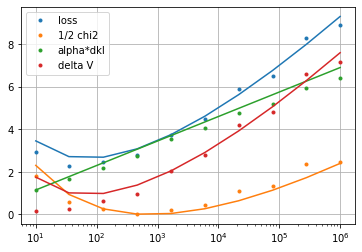

In [7]:
j = 0  # 0 or 1, depending on max/min g

colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red']  # ,'tab:purple','tab:brown','tab:pink',
          #   'tab:gray','tab:olive','tab:cyan']

mean_loss, std_loss = compute_mean_std(out1, 'lim_loss_num', j)
plt.plot(ns, mean_loss, '.', label='loss', c=colors[0])
plt.plot(ns, flatten(out2, 'lim_value'), c=colors[0])

mean, std = compute_mean_std(out1, 'lim_chi2', j)
plt.plot(ns, 1/2*np.array(mean), '.', label='1/2 chi2', c=colors[1])
plt.plot(ns, 1/2*np.array(flatten(out2, 'lim_chi2')), c=colors[1])

# overestimate of the chi2 with sqrt(log(n))
# plt.plot(ns, 1/2*((sigma*np.sqrt(2*np.log(ns)) - gexp)/sigma_exp)**2, label='1/2 chi2 est')

mean, std = compute_mean_std(out1, 'lim_dkl', j)
plt.plot(ns, alpha*np.array(mean), '.', label='alpha*dkl', c=colors[2])
plt.plot(ns, alpha*np.array(flatten(out2, 'lim_dkl')), c=colors[2])

mean, std = compute_mean_std(out1, 'dV')
plt.plot(ns, mean, '.', label='delta V', c=colors[3])
plt.plot(ns, flatten(out2, 'dV'), c=colors[3])

plt.grid()
plt.xscale('log')
# plt.yscale('log')
plt.legend()

### 2. when you might overcome the barrier

let's express $g_{exp}$ in units of $\sigma$ ($g_{exp} = a\sigma$), so we get an expression for the ratio $\sigma/\sigma_{exp}$ as a function of $\mathcal L_{lim}, \alpha, a, N$

but you are not considering the min. loss value, which anyway is almost constant around $\frac{1}{2} \frac{\alpha g_{exp}}{\sigma^2}$ if $\sigma_{exp}$ is very small (so that matching the $\chi^2$ is preferred to moving away from $P_0$)

In [36]:
from scipy.special import erfinv

In [37]:
bar_g = lambda n : np.sqrt(2)*erfinv(1 - 2/n)

def ratio(loss_lim, alpha, a, n):
    diff = loss_lim - alpha*np.log(n)
    # assert diff > 0, 'error: loss lim. value < alpha DKL'
    if diff > 0 : val = np.sqrt((loss_lim - alpha*np.log(n))*2)/np.abs(bar_g(n) - a)
    else: val = None
    return val

In [38]:
ratio(10, 0.1, 3, 100000)

3.3258440771932523

In [39]:
loss_lim = 5
alpha = 0.5
a = 3

log_ns = np.arange(1, 6, 0.1)
ns = np.unique([np.int64(k) for k in 10**log_ns])

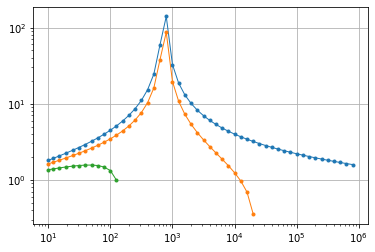

In [40]:
vals = [ratio(loss_lim, 0.1, a, n) for n in ns]
plt.plot(ns, vals, '.-')

vals = [ratio(loss_lim, 0.5, a, n) for n in ns]
plt.plot(ns, vals, '.-')

vals = [ratio(loss_lim, 1, a, n) for n in ns]
plt.plot(ns, vals, '.-')

plt.grid()
plt.xscale('log')
plt.yscale('log')

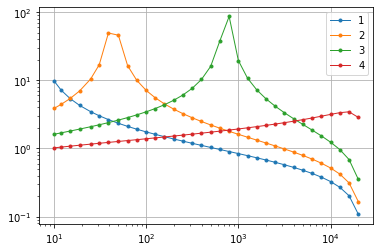

In [41]:
for a in [1, 2, 3, 4]:
    vals = [ratio(loss_lim, 0.5, a, n) for n in ns]
    plt.plot(ns, vals, '.-', label=a)

plt.grid()
plt.xscale('log')
plt.yscale('log')
plt.legend()

### 3. compare with Metropolis sampling

In [8]:
from basic_functions_bayesian import compute_single, compute, run_Metropolis
from basic_functions_gaussian import loss_fun

In [9]:
# alpha = 0.3

# sigma = 0.5
# gexp = 1.7
# sigma_exp = 0.1

n = 5000

In [10]:
p0 = np.ones(n)/n
g = np.random.normal(0, sigma, size=n)

# tau = 200
# g = sigma*autocorrelated_series(n, tau)

energy_function = lambda x : np.array([loss_fun(x, p0, g, gexp, sigma_exp, alpha)])

In [114]:
# n = np.int64(n/10)

# p0 = np.ones(n)/n

# g = g[::10]

In [11]:
def energy_function(x, if_jeffreys = False):

    out = loss_fun(x, p0, g, gexp, sigma_exp, alpha, if_cov=if_jeffreys)

    if if_jeffreys:
        energy = out[0]
        cov = out[-1]
        jeff = np.log(np.linalg.det(cov))
        energy -= jeff

    else:
        energy = out

    return np.array([energy])

Text(0.5, 0, 'n frames')

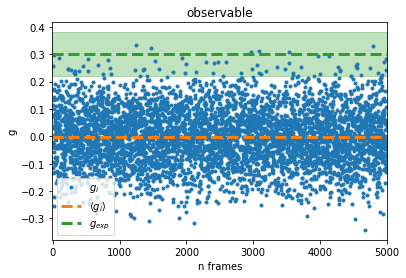

In [12]:
plt.rcParams['lines.linewidth'] = 3

plt.plot(g, '.', label=r'$g_i$')

plt.plot([-5, len(g) + 5], [np.mean(g), np.mean(g)], '--', label=r'$\langle g_i\rangle$')  # ,color='tab:blue')

plt.plot([-5, len(g) + 5], [gexp, gexp], '--', label=r'$g_{exp}$')
plt.fill_between([-5, len(g) + 5], [gexp - sigma_exp, gexp - sigma_exp], [gexp + sigma_exp, gexp + sigma_exp], alpha=0.3, color='tab:green')

plt.title('observable')
plt.legend(loc='lower left')
plt.xlim([-5, len(g) + 5])
plt.ylabel('g')
plt.xlabel('n frames')

In [13]:
dV = compute_depth_analytical(n, sigma, gexp, sigma_exp, alpha).dV

print(dV)

2.7819343522290536


In [14]:
out = compute_depth(n, np.array([g]), gexp, sigma_exp, alpha, if_scan=True, delta_lambda=100)

In [15]:
vars(out).keys()

dict_keys(['g', 'mini', 'min_lambda', 'min_loss', 'min_avg', 'gbar', 'lim_loss', 'lim_loss_num', 'lim_chi2', 'lim_dkl', 'dV', 'scan_lambdas', 'scan_results', 'scan_loss_min', 'scan_lambda_min', 'scan_avg_min'])

In [16]:
print(out.lim_loss, out.dV)

[array([4.33812097]), array([36.43598644])] 1.8502919673919678


In [50]:
print(out.lim_loss, out.dV)

[array([5.03678113]), array([40.66595704])] 3.3301647901535034


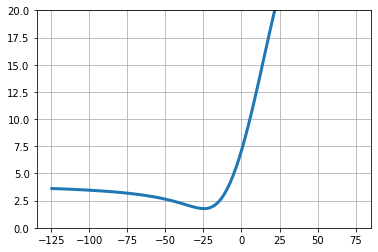

In [17]:
plt.plot(out.scan_lambdas, out.scan_results['lossf'])
plt.ylim([0, 20])
plt.grid()

Text(0.5, 1.0, 'derivative')

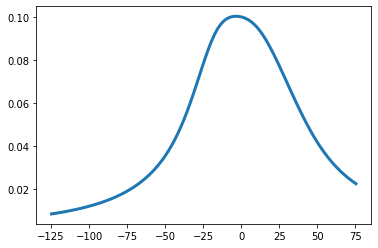

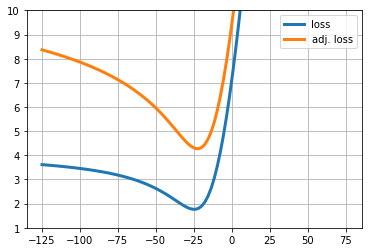

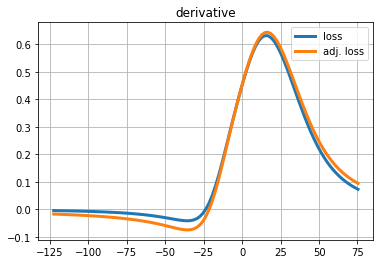

In [18]:
out_compute = compute(out.scan_lambdas, p0, g, gexp, sigma_exp, alpha)

plt.plot(out.scan_lambdas, out_compute['std_g'])

plt.figure()
plt.plot(out.scan_lambdas, out.scan_results['lossf'], label='loss')

adj_loss = out.scan_results['lossf'] - np.log(out_compute['jeffreys'])
plt.plot(out.scan_lambdas, adj_loss, label='adj. loss')
plt.grid()
plt.legend()
# plt.yscale('log')
plt.ylim([1, 10])

plt.figure()

def num_der(x, y):
    dy_dx = np.ediff1d(y)/np.ediff1d(x)
    return dy_dx

plt.plot(out.scan_lambdas[1:], num_der(out.scan_lambdas, out.scan_results['lossf']), label='loss')
plt.plot(out.scan_lambdas[1:], num_der(out.scan_lambdas, adj_loss), label='adj. loss')
plt.grid()
plt.legend()
plt.title('derivative')

In [19]:
my_energy_function = lambda x : energy_function(x, False)

out_Metropolis = run_Metropolis(np.zeros(1), 5., my_energy_function, n_steps=10000)

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900


In [20]:
my_energy_function = lambda x : energy_function(x, True)

out_J_Metropolis = run_Metropolis(np.zeros(1), 5., my_energy_function, n_steps=10000)

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900


In [26]:
mov_average = lambda x, m : [np.mean(x[i : (i + m)]) for i in range(len(x[:-m]))]

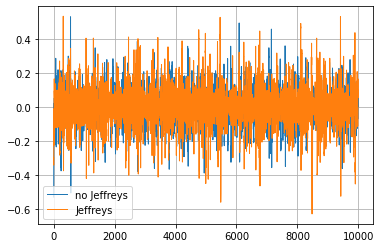

In [110]:
m = 10

av = mov_average(out_Metropolis[1], m)
av_J = mov_average(out_J_Metropolis[1], m)

# plt.plot(av)  # , '.', markersize=2)
# plt.plot(av_J)  # , '.', markersize=2)

plt.plot(np.ediff1d(av), label='no Jeffreys')
plt.plot(np.ediff1d(av_J), label='Jeffreys')

# plt.yscale('symlog')
plt.grid()
plt.legend()
# plt.xlim([0, 2000])

(7000.0, 9000.0)

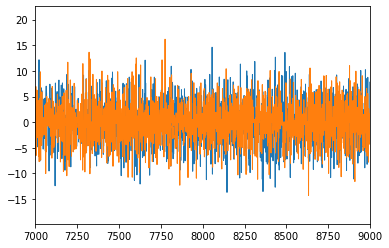

In [75]:
dif = np.ediff1d(out_Metropolis[0])
dif_J = np.ediff1d(out_J_Metropolis[0])

plt.plot(dif)
plt.plot(dif_J)
plt.xlim([7000, 9000])

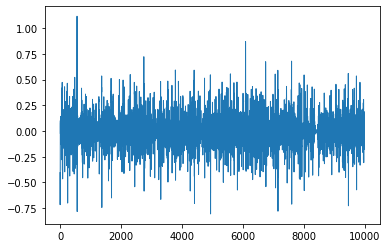

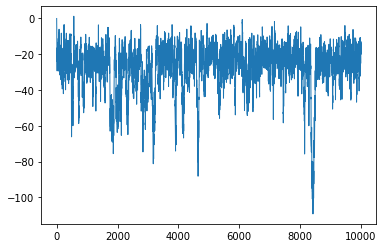

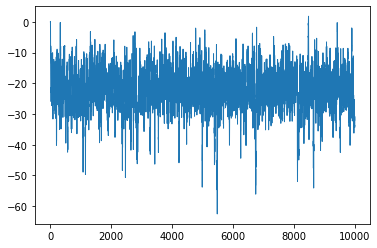

In [100]:
dif = np.ediff1d(out_Metropolis[1])
m_av = mov_average(dif, 5)

plt.figure()
plt.plot(m_av)

plt.figure()
plt.plot(out_Metropolis[0])

plt.figure()
plt.plot(out_J_Metropolis[0])

In [125]:
sign_dif

array([-1.,  0.,  0., ...,  1.,  0.,  1.], dtype=float32)

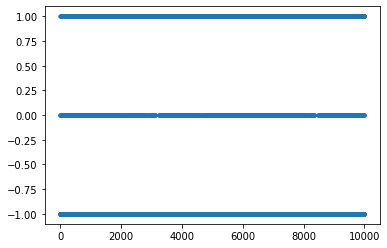

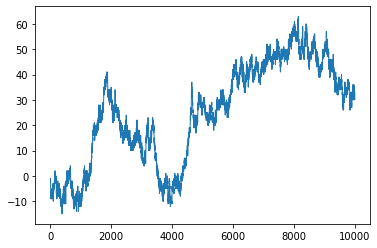

In [124]:
dif = np.ediff1d(out_Metropolis[1])
sign_dif = np.sign(dif)

plt.plot(sign_dif, '.')

q = np.cumsum(sign_dif)

plt.figure()
plt.plot(q)

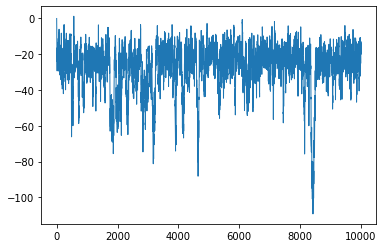

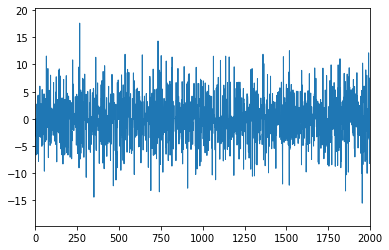

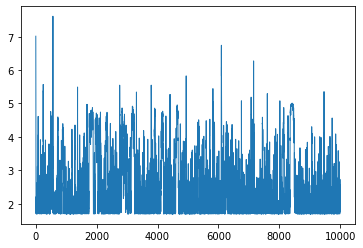

In [114]:
plt.plot(out_Metropolis[0])

plt.figure()
plt.plot(np.ediff1d(out_Metropolis[0]))
plt.xlim([0, 2000])

plt.figure()
plt.plot(out_Metropolis[1])

(0.0, 10.0)

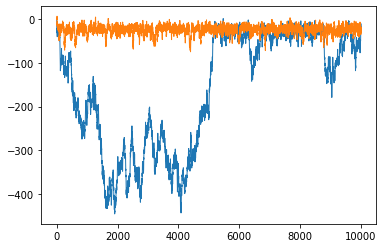

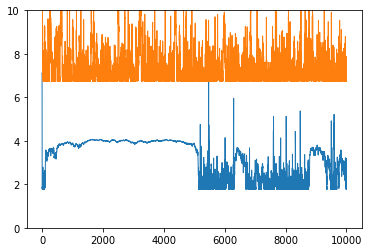

In [21]:
plt.rcParams['lines.linewidth'] = 1

plt.plot(out_Metropolis[0])
plt.plot(out_J_Metropolis[0])

plt.figure()
plt.plot(out_Metropolis[1])
plt.plot(out_J_Metropolis[1])
plt.ylim([0, 10])

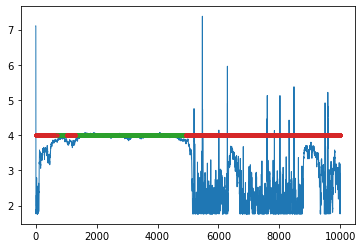

In [65]:
plt.plot(out_Metropolis[1])
plt.plot([0, 1e4], [4, 4])

wh = np.where(out_Metropolis[1] > 3.8)
wh2 = np.where(out_Metropolis[1] < 4.2)
wh = np.intersect1d(wh, wh2)

plt.plot(wh, 4*np.ones(len(wh)), '.')
plt.plot(wh_c, 4*np.ones(len(wh_c)), '.')



In [74]:
def my_group_fun(wh):
    
    my_group = []
    how_many = []

    my_group.append(wh[0])
    how_many.append(1)

    for i in range(len(wh) - 1):
        if (wh[i + 1] != wh[i] + 1):
            my_group.append(wh[i + 1])
            how_many.append(1)
        else:
            how_many[-1] += 1

    return my_group, how_many

In [75]:
out = my_group_fun(wh)

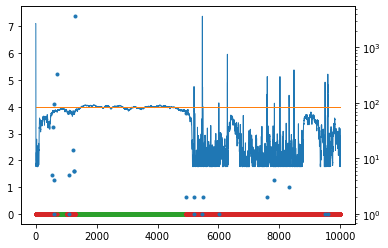

In [86]:
fig, ax1 = plt.subplots()

ax1.plot(out_Metropolis[1])
ax1.plot([0, 1e4], [4, 4])

wh = np.where(out_Metropolis[1] > 3.8)
wh2 = np.where(out_Metropolis[1] < 4.2)
wh = np.intersect1d(wh, wh2)

ax1.plot(wh, 0*np.ones(len(wh)), '.')
ax1.plot(wh_c, 0*np.ones(len(wh_c)), '.')

# plt.figure()
ax2 = ax1.twinx()
ax2.plot(out[0], out[1], '.')
ax2.set_yscale('log')

In [76]:
out[0]

[546,
 552,
 596,
 599,
 604,
 701,
 1091,
 1098,
 1103,
 1218,
 1252,
 1259,
 1284,
 4942,
 4948,
 5198,
 5200,
 5475,
 5484,
 6014,
 7606,
 7837,
 8324,
 9505,
 9591]

In [77]:
out[1]

[5,
 37,
 1,
 4,
 95,
 331,
 5,
 1,
 70,
 14,
 6,
 6,
 3641,
 2,
 65,
 1,
 2,
 1,
 2,
 1,
 2,
 4,
 3,
 1,
 1]

In [57]:
np.savetxt('wh.txt', wh)

In [63]:
wh_c = [i for i in np.arange(len(out_Metropolis[1])) if not i in wh]

In [64]:
wh_c

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 127,
 128,
 129,
 130,
 131,
 132,
 133,
 134,
 135,
 136,
 137,
 138,
 139,
 140,
 141,
 142,
 143,
 144,
 145,
 146,
 147,
 148,
 149,
 150,
 151,
 152,
 153,
 154,
 155,
 156,
 157,
 158,
 159,
 160,
 161,
 162,
 163,
 164,
 165,
 166,
 167,
 168,
 169,
 170,
 171,
 172,
 173,
 174,
 175,
 176,
 177,
 178,
 179,
 180,
 181,
 182,
 183,
 184,


In [54]:
my_group_fun(wh)

[546,
 552,
 596,
 599,
 604,
 701,
 1091,
 1098,
 1103,
 1218,
 1252,
 1259,
 1284,
 4942,
 4948,
 5198,
 5200,
 5475,
 5484,
 6014,
 7606,
 7837,
 8324,
 9505,
 9591]

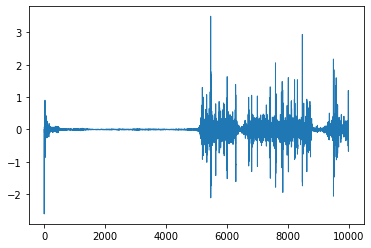

In [29]:
dif = np.ediff1d(out_Metropolis[1])
dif_J = np.ediff1d(out_J_Metropolis[1])

plt.plot(dif)

# plt.plot(mov_average(dif, 10))


# plt.plot(dif_J)
# plt.xlim([7000, 9000])

In [71]:
mu = np.mean(out_Metropolis[0])
std = np.std(out_Metropolis[0])

mu_J = np.mean(out_J_Metropolis[0])
std_J = np.std(out_J_Metropolis[0])

print(mu, std)
print(mu_J, std_J)

mini = np.min(out_Metropolis[0])
mini_J = np.min(out_J_Metropolis[0])

print(mini, mini_J)

print(mu - 5*std)
print(mu_J - 5*std_J)

-26.97475568867022 13.128960539228164
-22.00982804191747 7.052365184453829
-109.26112423844984 -62.52976904098823
-92.61955838481103
-57.27165396418661


In [56]:
print('acceptance: ', out_Metropolis[2], out_J_Metropolis[2])

acceptance:  0.8087 0.7621


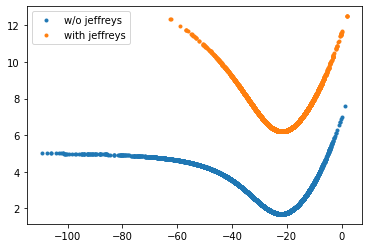

In [57]:
plt.plot(out_Metropolis[0], out_Metropolis[1], '.', label='w/o jeffreys')
plt.plot(out_J_Metropolis[0], out_J_Metropolis[1], '.', label='with jeffreys')
plt.legend()

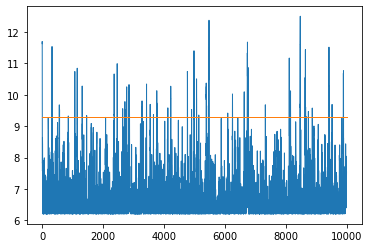

In [129]:
plt.plot(out_J_Metropolis[1])

mean = np.mean(out_J_Metropolis[1])
std = np.std(out_J_Metropolis[1])

plt.plot([0, 10000], [mean + 3*std, mean + 3*std])

### 4. effect of correlations

In [3]:
import sys

In [4]:
sys.path.append('../correlated_dirichlet')
from basic_correlations import autocorrelated_series

[[0.0003757056770443169, 0.9993502220446132], [0.007182733444258905, 1.0004310527988496], [0.00408787192231233, 0.9895254265123588], [-0.03782877354917045, 0.9836078839040449], [0.09334408974546636, 1.012399689972422]]


/u/i/igilardo/.local/lib/python3.6/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


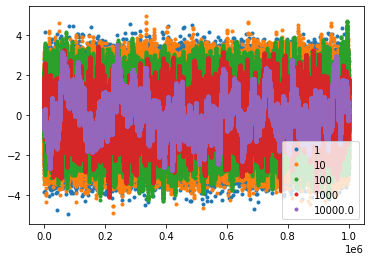

In [6]:
n = np.int64(1e6)

vals = []

for tau in [1, 10, 100, 1000, 1e4]:
    g = autocorrelated_series(n, tau)
    plt.plot(g, '.', label=tau)
    vals.append([np.mean(g), np.std(g)])

plt.legend()
print(vals)

[[0.0017541672681460696, 0.9800632990693868], [0.006794350718322064, 1.005189464194876], [0.011528697901118708, 0.9966906644891889], [-0.04409268485412697, 0.9864274846901046], [0.000499686483715601, 0.9946450702120474], [-0.008509331978552425, 1.0069634610515452], [-0.009782235134997925, 1.009168110247563], [0.01474939616327986, 0.9874792623097772], [-0.011612654642315989, 1.0068073526930728], [0.019071820859321128, 0.9980155742416728]]
[[0.0956605878574782, 1.0086099853527963], [-0.058771413920220276, 0.9928003987469725], [-0.0641133265517477, 1.0092835407543124], [0.07369629732450896, 1.0240623200080712], [-0.010884323630233865, 1.009599409069678], [-0.08683768494310301, 1.0194339252155278], [-0.023741715559730373, 0.9835968982666251], [-0.0014408918535159458, 0.9601839533855321], [-0.02877081622949006, 1.0020005893361115], [0.01069080451544726, 1.002071248019266]]
[[-0.18954204336608468, 0.8751769401634505], [-0.18043738733650247, 0.9549938840320257], [-0.08379628696906156, 0.96286

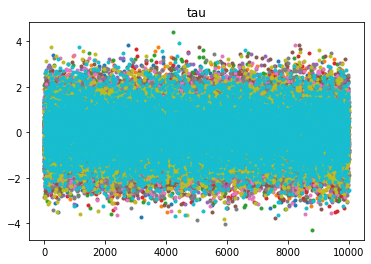

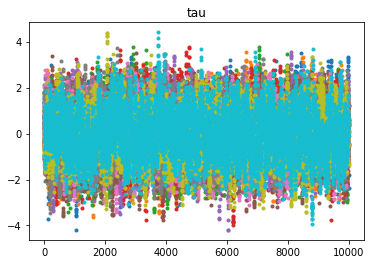

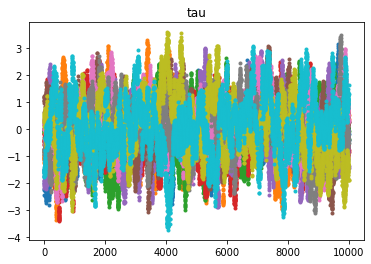

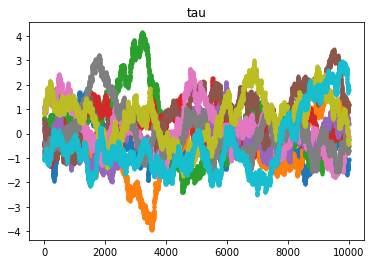

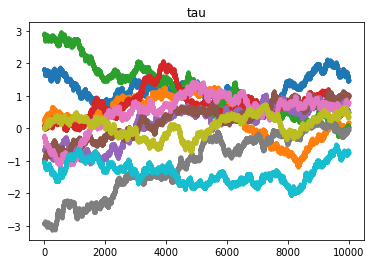

In [56]:
for tau in [1, 10, 100, 1000, 1e4]:
    vals = []
    plt.figure()
    
    for m in range(10):
        g = autocorrelated_series(n, tau)
        plt.plot(g, '.')
        vals.append([np.mean(g), np.std(g)])

    plt.title('tau')
    print(vals)

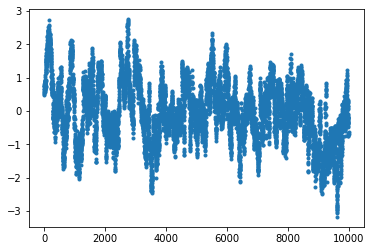

In [51]:
n = 10000
tau = 100

g = autocorrelated_series(n, tau)

plt.plot(g, '.')

In [52]:
np.std(g)

0.8994947792619705